In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
import cv2 as cv
from scipy import signal

uint8 (612, 604, 3)
float64 (612, 604)


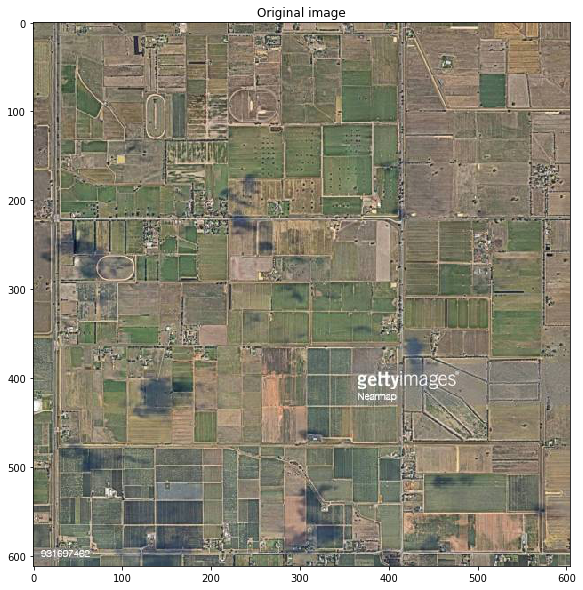

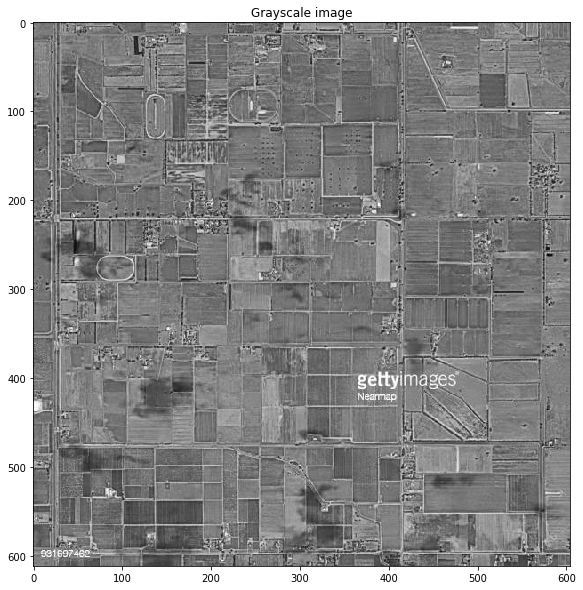

In [2]:
img = io.imread('./image-2.jpg')
print(img.dtype, img.shape)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.title("Original image")
plt.savefig("orignal_image.png")

img_gray = color.rgb2gray(img)*255
print(img_gray.dtype, img_gray.shape)
plt.figure(figsize=(10,10))
plt.imshow(img_gray, cmap='gray')
plt.title("Grayscale image")
plt.savefig("grayscale_image.png")

# Robust PCA

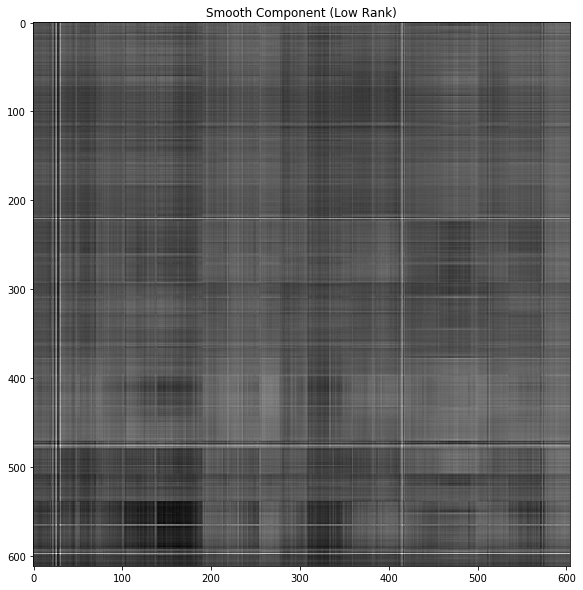

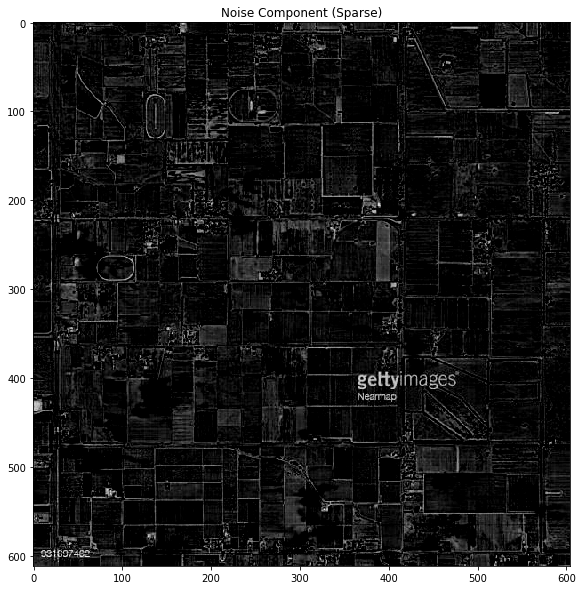

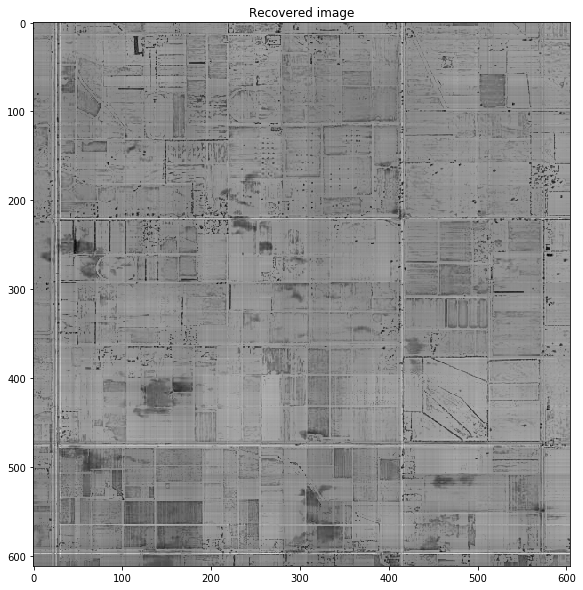

In [9]:
# adapted from example code

'''D = plt.imread('building.PNG')@np.array([0.2989, 0.5870, 0.1140, 0.])
D = np.round(255*D)
plt.imshow(D, vmin=0, vmax=255, cmap='gray')'''
lam = 1e-2
m, n = img_gray.shape
tol = 1e-7
maxIter = 1000

# % Initialize A,E,Y,u
Y = img_gray.copy()
norm2 = np.linalg.norm(Y, 2)
normInf = Y.max()/lam

# Y is Lagrangian multiplier for each pixel constaint that the
# reconstructed values must match truth
Y = Y/normInf

A_hat = np.zeros((m, n))  # Smooth component, L "low rank"
E_hat = np.zeros_like(A_hat)  # Noise component, S "sparse"

# Tune these
mu = 1.25/norm2
mu_bar = mu*1e7
rho = 1.5
d_norm = np.linalg.norm(img_gray, 'fro')
iter = 0
total_svd = 0
converged = False
stopCriterion = 1

# D is M the original data.
while not converged:
    iter += 1
    X = img_gray - A_hat + Y/mu
    
    # Soft threshold on scalars 
    E_hat = np.sign(X)*np.maximum(np.abs(X)-lam/mu, 0)
    
    # Soft threshold SVD
    u, s, vh = np.linalg.svd(img_gray-E_hat+Y/mu, full_matrices=False)
    svp = (s > 1/mu).sum()
    A_hat = (u[:, :svp]*(s[:svp]-1/mu))@vh[:svp]  # reconstruct
    total_svd += 1
    Z = img_gray-A_hat-E_hat  # Constraint violation
    Y = Y + mu*Z  # update lagragian multipliers
    mu = min(mu*rho, mu_bar)  # mu is augmented penalty coefficient
    
    # stop Criterion
    stopCriterion = np.linalg.norm(Z, 'fro') / d_norm
    if stopCriterion < tol:
        converged = True

plt.figure(figsize=(10,10))
plt.imshow(A_hat.astype('uint8'), cmap='gray')
plt.title("Smooth Component (Low Rank)")
plt.savefig("smooth_component.png")

plt.figure(figsize=(10,10))
E_hat = np.clip(E_hat, 0, 255)
plt.imshow(E_hat.astype('uint8'), cmap='gray')
plt.title("Noise Component (Sparse)")
plt.savefig("noise_component.png")

plt.figure(figsize=(10,10))
plt.imshow(img_gray - E_hat, cmap='gray')
plt.title("Recovered image")
plt.savefig("recovered_image.png")

# Edge detection

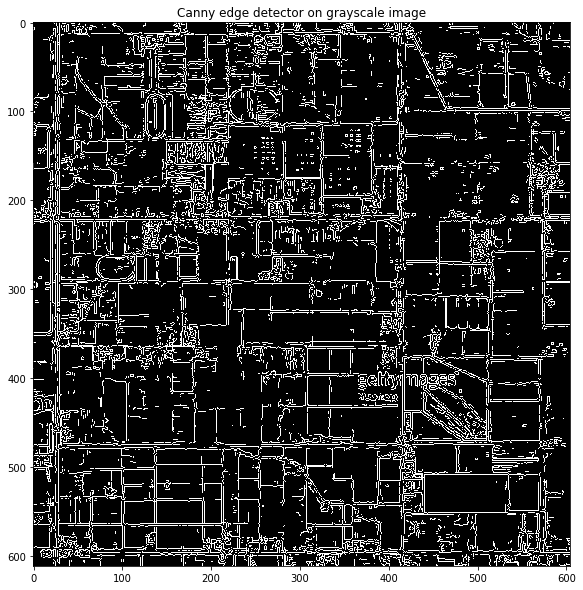

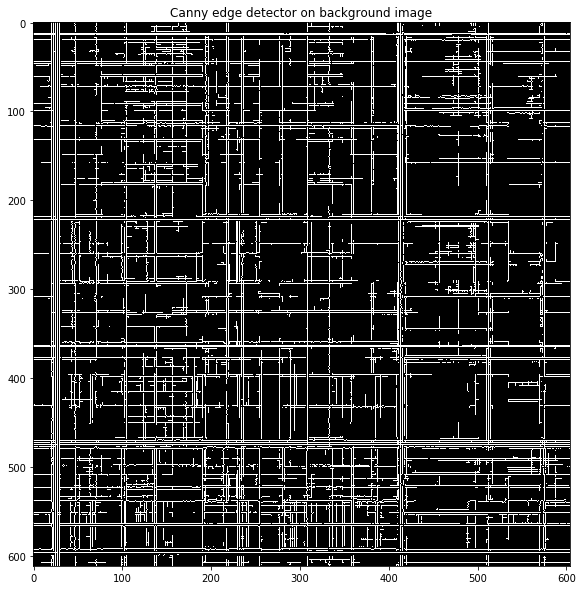

In [4]:
edges = cv.Canny(img_gray.astype('uint8'),150,200)
plt.figure(figsize=(10,10))
plt.imshow(edges, cmap='gray')
plt.title("Canny edge detector on grayscale image")
plt.savefig("canny_image.png")

back_edges = cv.Canny(A_hat.astype('uint8'),25,50)
plt.figure(figsize=(10,10))
plt.imshow(back_edges, cmap='gray')
plt.title("Canny edge detector on background image")
plt.savefig("canny_background_image.png")

In [5]:
mse = np.sum((edges - back_edges)**2) / (m*n)
print(mse)
corr = signal.correlate2d(edges, back_edges)
print(corr.mean())

0.20845507077002987
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


121.22315248810936


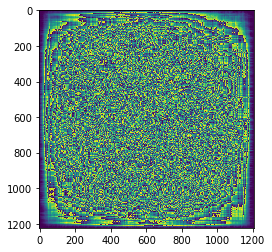

In [7]:
corr = signal.correlate2d(edges, back_edges)
print(corr.mean())
plt.imshow(corr)

In [13]:
corr.mean() / corr.max()

0.47538491171807595